In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error as mae

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = "https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/mauna_loa.csv"

df = pd.read_csv(path)

df.head()

,year,month,day,decimal,ppm,#days,1 yr ago,10 yr ago,since 1800
0,1974,5,19,1974.3795,333.34,6,-999.99,-999.99,50.36
1,1974,5,26,1974.3986,332.95,6,-999.99,-999.99,50.06
2,1974,6,2,1974.4178,332.32,5,-999.99,-999.99,49.57
3,1974,6,9,1974.4370,332.18,7,-999.99,-999.99,49.63
4,1974,6,16,1974.4562,332.37,7,-999.99,-999.99,50.07


In [3]:
df['date'] = pd.to_datetime(df[['year','month','day']])

In [4]:
df['ppm_fixed'] = df['ppm'].map(lambda x: np.nan if x < 0 else x)
df['ppm_fixed'].fillna(method='backfill', inplace=True)

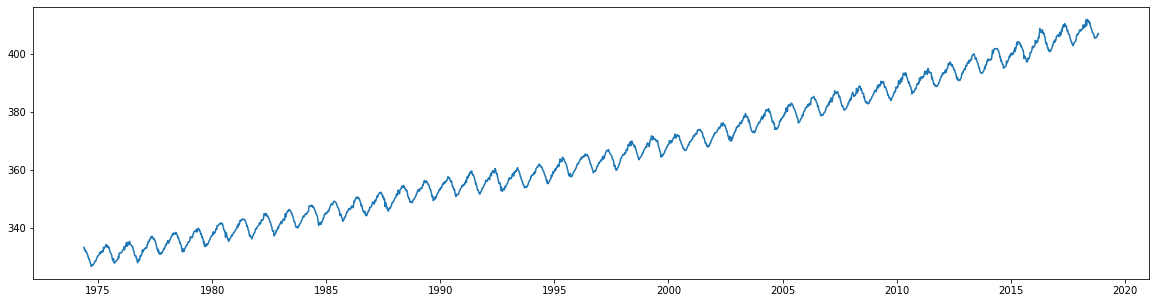

In [5]:
plt.figure(figsize=(20,5))
plt.plot(df.date,df.ppm_fixed);

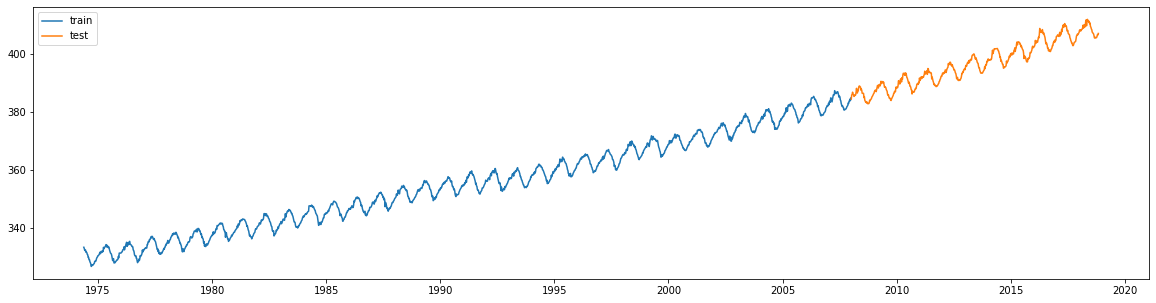

In [6]:
cut_year = 2008
train = df[df.year < cut_year ]
test = df[df.year >= cut_year]

plt.figure(figsize=(20,5))
plt.plot(train.date,train.ppm_fixed, label = 'train');
plt.plot(test.date,test.ppm_fixed, label = 'test');
plt.legend();

# Prophet

In [7]:
fb_df = train [['date', 'ppm_fixed']].copy()
fb_df.columns = ['ds', 'y']

fb_df.head()

,ds,y
0,1974-05-19,333.34
1,1974-05-26,332.95
2,1974-06-02,332.32
3,1974-06-09,332.18
4,1974-06-16,332.37


In [8]:
m = Prophet()
m.fit(fb_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = m.make_future_dataframe(periods=len(test), freq = 'W', include_history= False)
future.tail()

,ds
561,2018-10-07
562,2018-10-14
563,2018-10-21
564,2018-10-28
565,2018-11-04


In [10]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-06,385.044879,384.398361,385.413350,385.044879,385.044879,-0.118980,-0.118980,-0.118980,-0.118980,-0.118980,-0.118980,0.0,0.0,0.0,384.925899
1,2008-01-13,385.085336,384.642643,385.692640,385.085336,385.085336,0.055268,0.055268,0.055268,0.055268,0.055268,0.055268,0.0,0.0,0.0,385.140604
2,2008-01-20,385.125792,384.807732,385.860066,385.125792,385.125792,0.224634,0.224634,0.224634,0.224634,0.224634,0.224634,0.0,0.0,0.0,385.350426
3,2008-01-27,385.166249,385.045113,386.082846,385.166249,385.166249,0.384813,0.384813,0.384813,0.384813,0.384813,0.384813,0.0,0.0,0.0,385.551062
4,2008-02-03,385.206705,385.157221,386.227997,385.206705,385.206705,0.532063,0.532063,0.532063,0.532063,0.532063,0.532063,0.0,0.0,0.0,385.738768


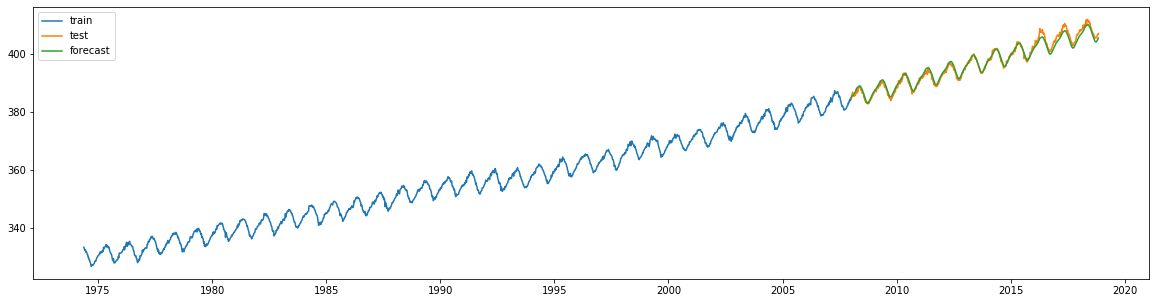

In [11]:
plt.figure(figsize=(20,5))
plt.plot(train.date,train.ppm_fixed, label = 'train');
plt.plot(test.date,test.ppm_fixed, label = 'test');
plt.plot(test.date,forecast.yhat, label = 'forecast');
plt.legend();

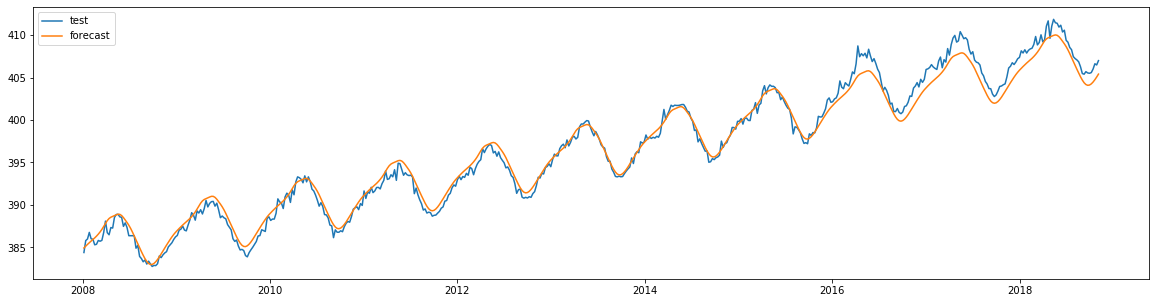

In [12]:
plt.figure(figsize=(20,5))
plt.plot(test.date,test.ppm_fixed, label = 'test');
plt.plot(test.date,forecast.yhat, label = 'forecast');
plt.legend();

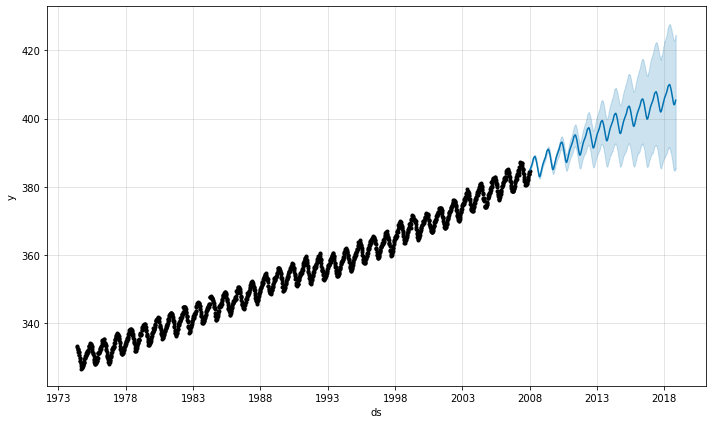

In [13]:
m.plot(forecast);

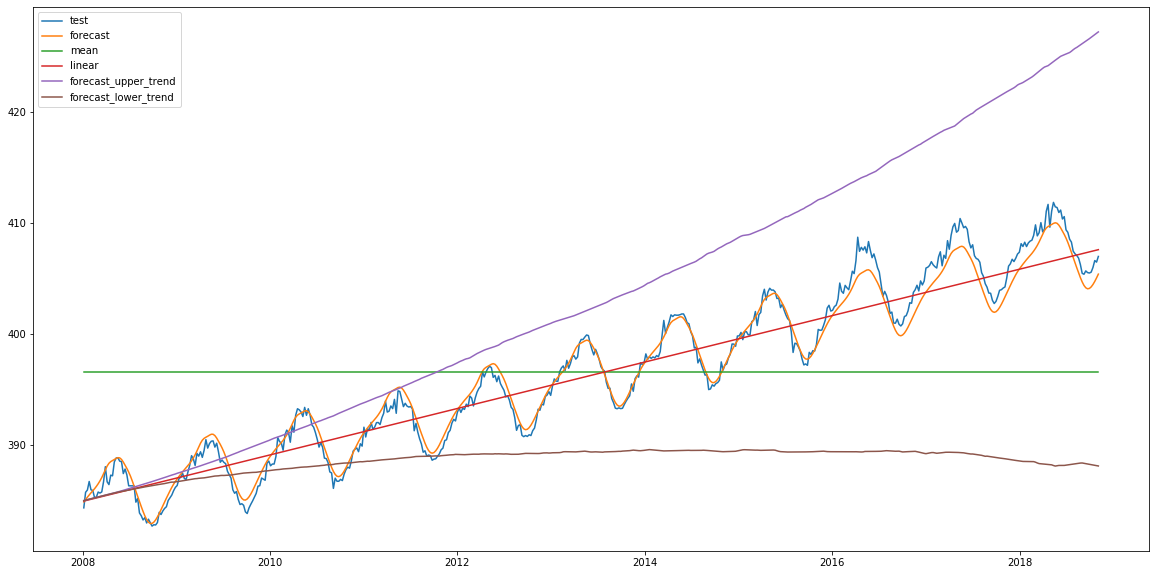

In [14]:
def linear_func(ppm_fixed, k=None, b=0):
    mean_value = np.mean(ppm_fixed)
    if k is None:
        return [mean_value] * len(ppm_fixed)
    
    return [idx*k+b for idx, _ in enumerate(ppm_fixed)]

plt.figure(figsize=(20,10))
plt.plot(test.date,test.ppm_fixed, label = 'test');
plt.plot(test.date, forecast.yhat, label = 'forecast');
plt.plot(test.date, linear_func(test.ppm_fixed), label = 'mean');
plt.plot(test.date, linear_func(test.ppm_fixed, k=0.04, b=385), label = 'linear');
plt.plot(test.date, forecast.trend_upper, label = 'forecast_upper_trend');
plt.plot(test.date, forecast.trend_lower, label = 'forecast_lower_trend');
plt.legend();

In [15]:
print('mean = ', mae(test.ppm_fixed, linear_func(test.ppm_fixed)))
print('linear = ', mae(test.ppm_fixed, linear_func(test.ppm_fixed, k=0.04, b=385)))
print('forecast_trend = ', mae(test.ppm_fixed, forecast.trend))
print('forecast_upper_trend = ', mae(test.ppm_fixed, forecast.trend_upper))
print('forecast_lower_trend = ', mae(test.ppm_fixed, forecast.trend_upper))

mean =  6.5032341520059
linear =  2.0388869257950533
forecast_trend =  2.009307385234449
forecast_upper_trend =  7.158130770345815
forecast_lower_trend =  7.158130770345815
